<a href="https://colab.research.google.com/github/kjmobile/lb/blob/main/c2_Difference%20in%20Difference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Research Question

- How does the presence of a nearby incinerator impact the change in residential property values over time?

# Research Method

- **Difference** in **Difference** Analysis

- Difference (price increase between 1978 to 1981) in Difference (existence of incinerator nearby)

## Data:
- **year**: The year when the data was recorded.  
- **age**: The age of the building or house.  
- **agesq**: The squared value of the building age, used to capture nonlinear relationships.  
- **nbh**: Identifier for a specific neighborhood or area.  
- **cbd**: Distance to the Central Business District (CBD).  
- **intst**: Intensity of nearby major roads or traffic.  
- **lintst**: Logarithm of `intst`, reflecting scale adjustment and nonlinear effects.  
- **price**: Raw price data of the house.  
- **rooms**: Number of rooms in the house.  
- **area**: Total area of the house.  
- **land**: Size of the land or lot.  
- **baths**: Number of bathrooms in the house.  
- **dist**: Distance to a specific reference point (e.g., CBD or incinerator).  
- **ldist**: Logarithm of `dist`.  
- **wind**: Wind direction or other related environmental variable.  
- **lprice**: Logarithm of `price`.  
- **y81**: Dummy variable indicating the year 1981.  
- **larea**: Logarithm of `area`.  
- **lland**: Logarithm of `land`.  
- **y81ldist**: Interaction term between 1981 (`y81`) and `ldist`.  
- **lintstsq**: Squared value of `lintst`.  
- **nearinc**: Dummy variable indicating proximity to an incinerator (1 = near, 0 = far).  
- **y81nrinc**: Interaction term between 1981 (`y81`) and proximity to the incinerator (`nearinc`).  
- **rprice**: Residental housing price.  
- **lrprice**: Logarithm of `rprice`.  

In [ ]:
# !pip install wooldridge
# !pip install ISLP

In [ ]:
# Code
import wooldridge as woo
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf  # note this
import ISLP
from ISLP.models import (ModelSpec as MS, summarize,poly)

In [ ]:
# all three approaches produce the same results

In [ ]:
# 1 Using formula.api : difference in difference (DiD) :
import statsmodels.formula.api as smf
kielmc = woo.dataWoo('kielmc')

mod_did_f = smf.ols(formula='np.log(rprice) ~ nearinc*C(year)', data=kielmc)
results_did_f = mod_did_f.fit()
summarize(results_did_f)

,coef,std err,t,P>|t|
Intercept,11.2854,0.031,369.839,0.000
C(year)[T.1981],0.1931,0.045,4.261,0.000
nearinc,-0.3399,0.055,-6.231,0.000
nearinc:C(year)[T.1981],-0.0626,0.083,-0.751,0.453


In [ ]:
# 2 Manual Design Matrix Approach
import statsmodels.api as sm
kielmc = woo.dataWoo('kielmc')

kielmc = pd.get_dummies(kielmc, columns=['year'], drop_first=True).astype(int)
kielmc['nearinc_year_1981'] = kielmc['nearinc'] * kielmc['year_1981']

X = kielmc[['nearinc', 'year_1981', 'nearinc_year_1981']]
X = sm.add_constant(X)

y = np.log(kielmc['rprice'])
mod_did_a = sm.OLS(y, X)
results_did_a = mod_did_a.fit()
summarize(results_did_a)

,coef,std err,t,P>|t|
const,11.2854,0.031,369.838,0.000
nearinc,-0.3399,0.055,-6.231,0.000
year_1981,0.1931,0.045,4.260,0.000
nearinc_year_1981,-0.0626,0.083,-0.751,0.453


In [ ]:
# 3. ModelSpec-Based Design Matrix Approach : using MS()
import ISLP
from ISLP.models import (ModelSpec as MS, summarize,poly)
kielmc = woo.dataWoo('kielmc')

kielmc['year'] = kielmc['year'].astype('category')
spec = MS(['nearinc', 'year', ('nearinc', 'year')],  categorical_features='year', categorical_encoders={} )
X = spec.fit_transform(kielmc)
y = np.log(kielmc['rprice'])
results_did_ms = sm.OLS(y, X).fit()

print(summarize(results_did_ms))
print(results_did_ms.summary())


                 coef  std err        t  P>|t|
intercept     11.2854    0.031  369.839  0.000
nearinc       -0.3399    0.055   -6.231  0.000
year[1981]     0.1931    0.045    4.261  0.000
nearinc:year  -0.0626    0.083   -0.751  0.453
                            OLS Regression Results                            
Dep. Variable:                 rprice   R-squared:                       0.246
Model:                            OLS   Adj. R-squared:                  0.239
Method:                 Least Squares   F-statistic:                     34.47
Date:                Thu, 23 Jan 2025   Prob (F-statistic):           2.62e-19
Time:                        13:40:21   Log-Likelihood:                -105.68
No. Observations:                 321   AIC:                             219.4
Df Residuals:                     317   BIC:                             234.4
Df Model:                           3                                         
Covariance Type:            nonrobust                 

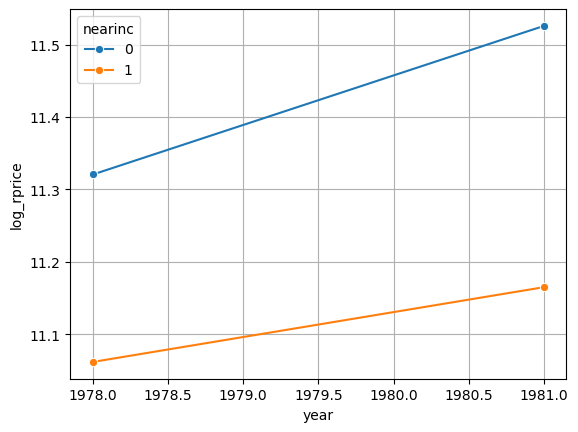

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

summary = kielmc.groupby(['year', 'nearinc'], observed=False)['rprice'].mean().reset_index()
summary['log_rprice'] = np.log(summary['rprice'])
sns.lineplot(data=summary, x='year', y='log_rprice', hue='nearinc', marker='o')
plt.grid()

# Report:



- Proximity to the Incinerator (nearinc):
Properties located near the incinerator have log(prices) approximately 34%(28.8% after exponentiating) lower than those farther away.


- Effect of the Year 1981 (y81):
Property log(prices) increased by 19.3% (21.3% after exponentiating) from 1978 to 1981, regardless of proximity to the incinerator (p < 0.001).

- Interaction Term (y81 × nearinc):
There is no significant difference in the rate of price change over time between properties near the incinerator and those farther away (p = 0.453).
(Interaction effect is not statistically significant.)

**DID Conclusion**:

While proximity to the incinerator significantly reduces property values overall, the rate of price change over time does not differ meaningfully between treated (near the incinerator) and control (farther away) groups.